# 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import itertools

%load_ext autoreload
%autoreload 2

# 2. Setup IGANN Model

In [2]:
import importlib
import igann

importlib.reload(igann)

from igann import IGANN

model = IGANN(task='regression', n_hid=10, interaction_detection_method='dt')

# 3. Ames Housing Dataset

## 3.1 Load Data

In [3]:
from sklearn.datasets import fetch_openml

data = fetch_openml(data_id=42165, as_frame=True)
df = data.frame

# Feature-Auswahl
selected_features = ['LotArea', 'OverallQual', 'YearBuilt', '1stFlrSF', 'GrLivArea',
                     'Neighborhood', 'BldgType', 'HouseStyle', 'CentralAir', 'ExterQual']

X = df[selected_features]
y = df['SalePrice']

X.head()

,LotArea,OverallQual,YearBuilt,1stFlrSF,GrLivArea,Neighborhood,BldgType,HouseStyle,CentralAir,ExterQual
0,8450,7,2003,856,1710,CollgCr,1Fam,2Story,Y,Gd
1,9600,6,1976,1262,1262,Veenker,1Fam,1Story,Y,TA
2,11250,7,2001,920,1786,CollgCr,1Fam,2Story,Y,Gd
3,9550,7,1915,961,1717,Crawfor,1Fam,2Story,Y,TA
4,14260,8,2000,1145,2198,NoRidge,1Fam,2Story,Y,Gd


In [4]:
# scale data
scaler = StandardScaler()
X_num = scaler.fit_transform(X.iloc[:,:5])
X = pd.concat([pd.DataFrame(X_num, columns=X.columns[:5]), X.iloc[:,5:]], axis=1)

y = (y - y.mean()) / y.std()

X.head()

,LotArea,OverallQual,YearBuilt,1stFlrSF,GrLivArea,Neighborhood,BldgType,HouseStyle,CentralAir,ExterQual
0,-0.207142,0.651479,1.050994,-0.793434,0.370333,CollgCr,1Fam,2Story,Y,Gd
1,-0.091886,-0.071836,0.156734,0.257140,-0.482512,Veenker,1Fam,1Story,Y,TA
2,0.073480,0.651479,0.984752,-0.627826,0.515013,CollgCr,1Fam,2Story,Y,Gd
3,-0.096897,0.651479,-1.863632,-0.521734,0.383659,Crawfor,1Fam,2Story,Y,TA
4,0.375148,1.374795,0.951632,-0.045611,1.299326,NoRidge,1Fam,2Story,Y,Gd


## 3.2 Train Model

In [5]:
model.fit(X, y)

## 3.3 Model Evaluation

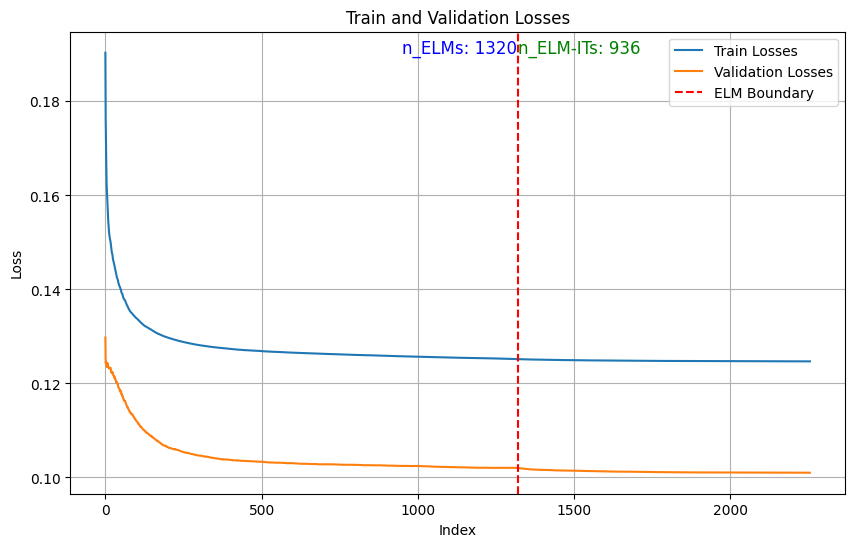

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses+model.train_losses_it, label="Train Losses")
plt.plot(model.val_losses+model.val_losses_it, label="Validation Losses")
plt.axvline(x=len(model.train_losses), color="red", linestyle="--", label="ELM Boundary")
plt.text(len(model.train_losses) - 2, max(model.train_losses), "n_ELMs: "+str(len(model.train_losses)), horizontalalignment='right', color="blue", fontsize=12)
plt.text(len(model.train_losses) + 2, max(model.train_losses), "n_ELM-ITs: "+str(len(model.train_losses_it)), horizontalalignment='left', color="green", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Train and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

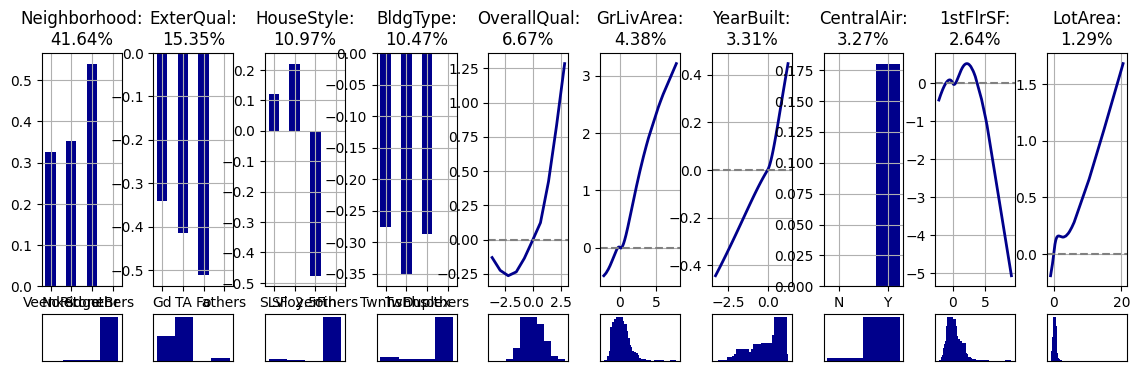

In [280]:
model.plot_single(show_n=10)

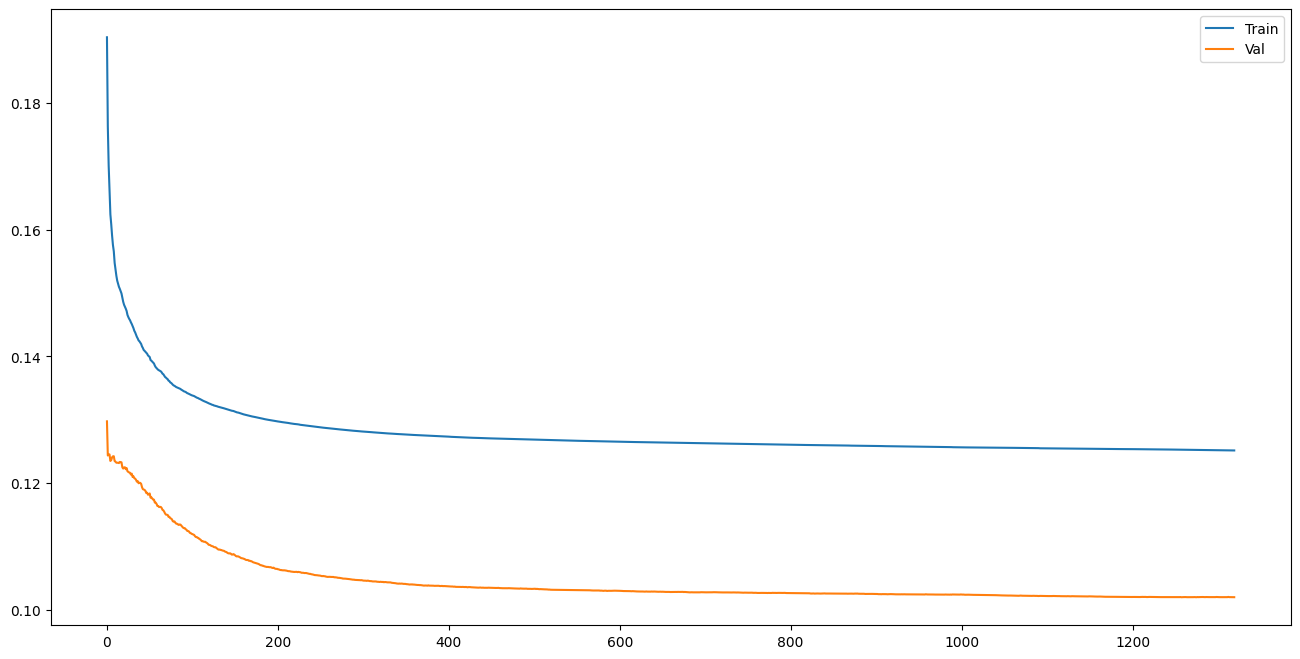

In [7]:
model.plot_learning()

## 3.3 Infos zu Model

### 3.3.1 Alle Attribute

In [51]:
ignored_attributes = ["regressor_predictions", "unique", "hist", "y_hats", 'y_hats_val', "regressors", "regressors_it", "train_losses", "train_losses_it", "val_losses_it", "val_losses", "regressor_predictions_it"]

for attr, value in vars(model).items():
    if attr not in ignored_attributes:
        print(f"{attr}: {value}")

task: regression
n_hid: 10
elm_scale: 1
elm_alpha: 1
init_reg: 1
act: elu
n_estimators: 5000
early_stopping: 50
sparse: 0
device: cpu
random_state: 1
optimize_threshold: False
verbose: 0
interaction_detection_method: dt
boost_rate: 0.1
target_remapped_flag: False
init_classifier: Lasso(alpha=1)
criterion: MSELoss()
boosting_rates: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0

In [27]:
model.dummy_encodings

{'x3_B': 'x3', 'x3_C': 'x3', 'x4_Y': 'x4'}

In [ ]:
model.feature_names

# 3. Entwicklung Interaction Pair Selection

In [22]:
X_neu = model._preprocess_feature_matrix(X)
X_neu

AttributeError: 'IGANN' object has no attribute 'get_dummies'

In [49]:
model._constraint_dt(X_neu, y)

In [ ]:
model.best_combination

# number of elements in list
len(model.best_combination)

[2, 5, 6, 7, 8]

# 4. Synthetic Dataset

## 4.1 Create Data

In [53]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 1000

# Generate numeric variables
x1 = np.random.uniform(0, 10, n_samples)  # Continuous variable 1
x2 = np.random.uniform(0, 5, n_samples)   # Continuous variable 2

# Generate categorical variables
categories = ['A', 'B', 'C', 'D']
x3 = np.random.choice(categories, size=n_samples, p=[0.4, 0.3, 0.1, 0.2])  # Categorical variable 1
x4 = np.random.choice(['X', 'Y'], size=n_samples, p=[0.5, 0.5])  # Categorical variable 2

# Create interaction effect: x1 interacts with x3
interaction_effect = np.zeros(n_samples)
for i, cat in enumerate(categories):
    interaction_effect[x3 == cat] = x1[x3 == cat] * (i + 1)

# Generate the target variable (y) with noise
y = (
    2 * x1 +                   # Linear effect of x1
    3 * np.sin(x2) +           # Non-linear effect of x2
    interaction_effect +       # Interaction effect between x1 and x3
    np.random.normal(0, 1, n_samples)  # Random noise
)

# Combine into a DataFrame
X = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
})


# Display the first few rows of the dataset
print(X.head())


         x1        x2 x3 x4
0  3.745401  0.925665  A  Y
1  9.507143  2.709505  A  Y
2  7.319939  4.364729  D  X
3  5.986585  3.661124  A  Y
4  1.560186  4.032806  A  Y


## 4.2 Scale Data

In [54]:
# scale data
scaler = StandardScaler()
X_num = scaler.fit_transform(X.iloc[:,:2])
X = pd.concat([pd.DataFrame(X_num, columns=X.columns[:2]), X.iloc[:,2:]], axis=1)

y = (y - y.mean()) / y.std()

X.head()

,x1,x2,x3,x4
0,-0.396301,-1.102179,A,Y
1,1.576957,0.119447,A,Y
2,0.827893,1.252992,D,X
3,0.371251,0.771143,A,Y
4,-1.144685,1.025681,A,Y


In [56]:
model.fit(X, y)

No feature combination found. All decision trees only use one feature. Model does not capture interactions.
Best interaction pair: None


TypeError: object of type 'NoneType' has no len()

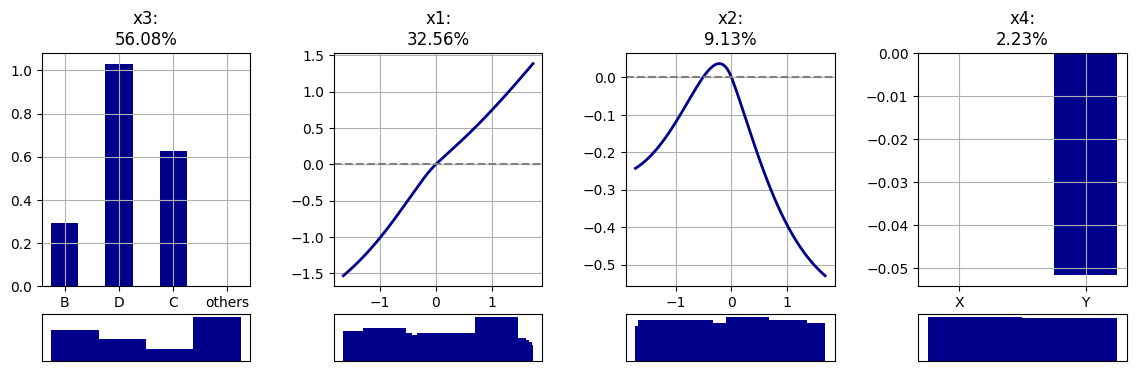

In [ ]:
model.plot_single(show_n=4)

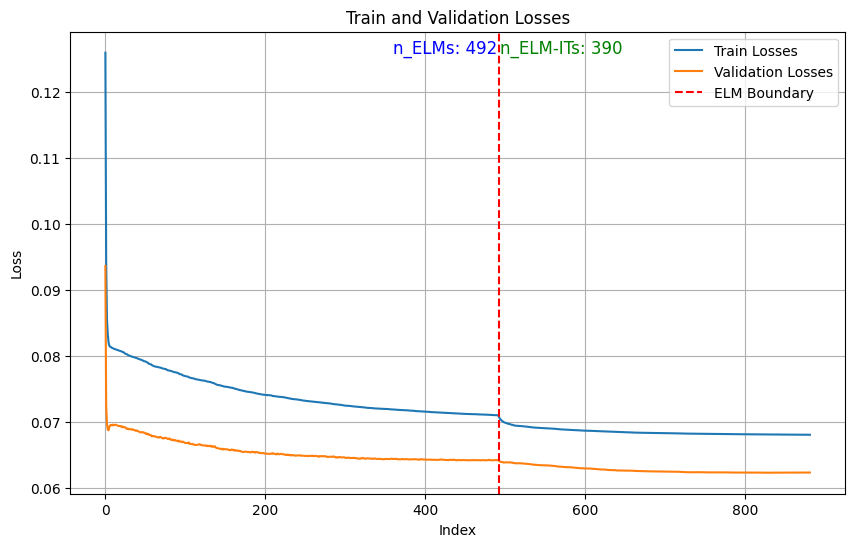

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses+model.train_losses_it, label="Train Losses")
plt.plot(model.val_losses+model.val_losses_it, label="Validation Losses")
plt.axvline(x=len(model.train_losses), color="red", linestyle="--", label="ELM Boundary")
plt.text(len(model.train_losses) - 2, max(model.train_losses), "n_ELMs: "+str(len(model.train_losses)), horizontalalignment='right', color="blue", fontsize=12)
plt.text(len(model.train_losses) + 2, max(model.train_losses), "n_ELM-ITs: "+str(len(model.train_losses_it)), horizontalalignment='left', color="green", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Train and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

# 5. Dev FAST Interaction Detection

## 5.1 Train Univariate Model

# 6. catelematic13


In [57]:
cat = pd.read_csv('/Users/maximilianveitl/Documents/Studium/Master/3. Semester/Masterarbeit/catelematic13.csv')
cat.head()

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609,Urban,6213.71,25,...,1,0,0,3,1,0,0,0,1,5100.171753
1,182,44,Female,3,Married,Commute,575,Urban,12427.42,20,...,58,24,11,1099,615,219,101,40,1,883.554840
2,184,48,Female,6,Married,Commute,847,Urban,12427.42,14,...,0,0,0,0,0,0,0,0,0,0.000000
3,183,71,Male,6,Married,Private,842,Urban,6213.71,43,...,0,0,0,0,0,0,0,0,0,0.000000
4,183,84,Male,10,Married,Private,856,Urban,6213.71,65,...,2,0,0,325,111,18,4,2,0,0.000000


In [58]:
X = cat[['Duration', 'Insured.age', 'Insured.sex', 'Car.age', 'Marital', 'Car.use', 'Credit.score', 'Region', 'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven', 'Total.miles.driven', 'Pct.drive.2hrs', 'Pct.drive.4hrs', 'Pct.drive.wkday', 'Pct.drive.wkend', 'Pct.drive.rush.am', 'Pct.drive.rush.pm', 'Avgdays.week', 'Accel.06miles', 'Accel.14miles', 'Brake.06miles', 'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity12', 'Right.turn.intensity08', 'Right.turn.intensity12']]
y = cat['AMT_Claim']

In [59]:
# scale data
scaler = StandardScaler()
continuous_features = ['Duration', 'Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven', 'Total.miles.driven', 'Pct.drive.2hrs', 'Pct.drive.4hrs', 'Pct.drive.wkday', 'Pct.drive.wkend', 'Pct.drive.rush.am', 'Pct.drive.rush.pm', 'Avgdays.week', 'Accel.06miles', 'Accel.14miles', 'Brake.06miles', 'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity12', 'Right.turn.intensity08', 'Right.turn.intensity12']
X_num = scaler.fit_transform(X[continuous_features])
X_cat = X.drop(columns=continuous_features)
X = pd.concat([pd.DataFrame(X_num, columns=continuous_features), X_cat], axis=1)

y = (y - y.mean()) / y.std()

In [66]:
3 < np.inf

True

In [60]:
model.fit(X, y)

No feature combination found. All decision trees only use one feature. Model does not capture interactions.
Best interaction pair: None


TypeError: object of type 'NoneType' has no len()

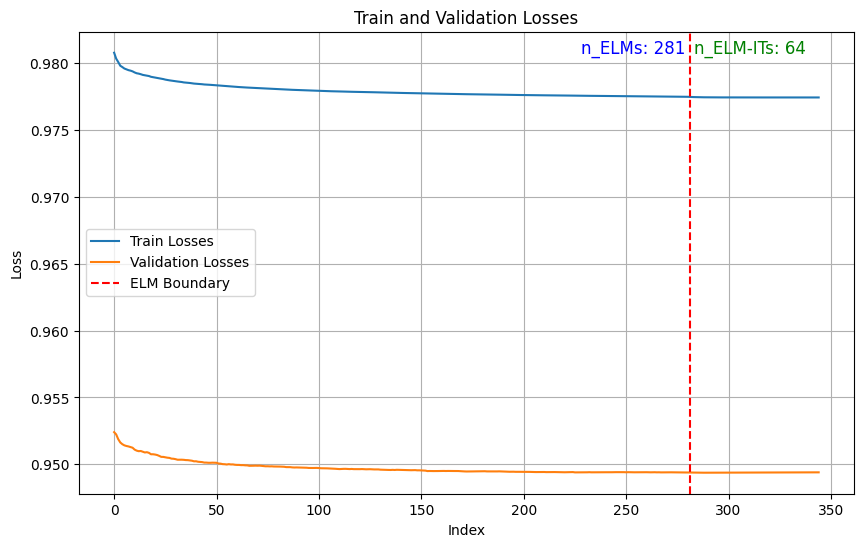

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses+model.train_losses_it, label="Train Losses")
plt.plot(model.val_losses+model.val_losses_it, label="Validation Losses")
plt.axvline(x=len(model.train_losses), color="red", linestyle="--", label="ELM Boundary")
plt.text(len(model.train_losses) - 2, max(model.train_losses), "n_ELMs: "+str(len(model.train_losses)), horizontalalignment='right', color="blue", fontsize=12)
plt.text(len(model.train_losses) + 2, max(model.train_losses), "n_ELM-ITs: "+str(len(model.train_losses_it)), horizontalalignment='left', color="green", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Train and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Achtung Spaltenindices nicht gleich cat indices da in diesem Notebook davor X_num und X_cat davor schon zusammengefügt wurden
model.best_combination

[22, 26]